# **A python implementation of the PAP-GR optimization algorithm**
December 2024 - Toulouse INP/ENSEEIHT<br />
Mohamed SAADI (Toulouse INP/ENSEEIHT \& [IMFT](https://www.imft.fr/en/accueil-english/); mohamed.saadi@toulouse-inp.fr)

Last update: 2025-05-20

## **1. Introduction: Libraries and functions**

This notebook provides a `python` implementation of the PAP-GR optimization method (see, for example, [Mathevet, 2005](https://webgr.inrae.fr/content/download/855/8253?version=1)), which is the default optimization algorithm implemented within the [`airGR`](https://hydrogr.github.io/airGR/) `R` package [(Coron et al., 2017)](https://doi.org/10.1016/j.envsoft.2017.05.002). This `python` implementation is a simple translation of the `R` function [`airGR::Calibration_Michel()`](https://gitlab.irstea.fr/HYCAR-Hydro/airgr/-/blob/dev/R/Calibration_Michel.R). The optimization algorithm contains two main steps:

1. A first global screening of the parameter space, which tests an initial list of $3^n$ initial parameter sets, with $n$ the dimension of the parameter set. (For example, $n=4$ for GR4J.) The best parameter set according to the chosen loss function is taken as an initial starting point for the next, second step.

2. A second local screening method based on the gradient-descent approach, which takes as an initial starting point the best parameter set reached by the global screening.

To control this `python` implementation, we show an example of model optimization using the daily rainfall-runoff model GR4J (*Génie Rural à 4 paramètres au pas de temps Journalier*; [Perrin et al., 2003](https://doi.org/10.1016/S0022-1694(03)00225-7)), which is a daily conceptual model that computes daily discharge knowing the input catchment-scale precipitation and potential evapotranspiration. This model contains $4$ catchment-scale parameters ($X_1~[\text{mm}]$, $X_2~[\text{mm}]$, $X_3~[\text{mm}]$, and $X_4~[\text{d}]$) that should be calibrated. For a detailed presentation of GR4J, check [this paper by Perrin et al. (2003)](https://doi.org/10.1016/S0022-1694(03)00225-7).

The optimization algorithm is called using the function `calibration_PAPGR()`. This function relies on other supporting functions (`transfo_param`, `NewCandidates`, `NewCandidatesLoc`) used to transform and create parameter sets, which are helpful to map the landscape of the objective function. This calibration function needs a specification of:

1. the model to be trained `run_model` and several other model-specific choices: the parameters that should be trained `msk_optim`, the constant values for the parameters that will not be trained `val_nonoptim`, and the starting parameter distribution `StartParamDistribT` which is provided by default for the model to be optimized,

2. the catchment dataset `data_cat` and the training time steps `msk_train`, and 
    
3. the loss function `loss_func` and whether this loss function should be maximized or minimized.

In addition, the GR4J model is run using the function `run_GR4J`, which wrapps the core model class `ModelGr4j` implemented within the [`hydrogr`](https://github.com/SimonDelmas/hydrogr/blob/master/example/calibrating_gr4j.ipynb) library. This function provides simulated discharge from provided `inputs` and parameter set `parameters`.

In [1]:
## libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os, re, time, sys
from hydrogr import InputDataHandler, ModelGr4j

## transformation of parameters for GR4J
def transfo_param(params_in, dir_ = "R_to_T"):
    ''' transform parameters for efficient sampling of the loss function
    params_in: (n_r, n) array with n_r the number of parameter sets and n their dimenstion (n=4 for GR4J)
    dir_     : "R_to_T" to obtain transformed parameter sets; "T_to_R" to undo transformation.
    '''
    params_out = params_in.copy()
    if dir_ == "T_to_R":
        params_out[:,0] = np.exp(params_in[:,0])
        params_out[:,1] = np.sinh(params_in[:,1])
        params_out[:,2] = np.exp(params_in[:,2])
        params_out[:,3] = 20. + 19.5*(params_in[:,3] - 9.99)/19.98
    
    if dir_ == "R_to_T":
        params_out[:,0] = np.log(params_in[:,0])
        params_out[:,1] = np.arcsinh(params_in[:,1])
        params_out[:,2] = np.log(params_in[:,2])
        params_out[:,3] = 9.99 + 19.98*(params_in[:,3] - 20.)/19.5
    return params_out

## function to propose new candidates of parameter sets from a distribution (Latin Hypercube)
def NewCandidates(distribParam):
    '''provides candidates of parameter from a distribution of parameter values
    distribParam: nr x n, where n is the dimension of the parameter set, and nr the number of parameter sets
    output of dimension nr^n x n
    '''
    new_array = np.array([y.flatten() for y in np.meshgrid(*[x for x in distribParam.T])])
    return np.unique(new_array.T, axis = 0)

## function to propose new candidates of parameter sets in the vicinity of a parameter set
def NewCandidatesLocal(new_param, search_ranges, msk_optim, pace):
    '''local sampling in all directions in the vicinity of a parameter set'''
    if(new_param.shape[0] != 1):
        print("You should send only one parameter set to this function.\n") 
        sys.exit(1)
    nparam = new_param.shape[1]
    vector_params = np.ones((2*nparam,nparam))*np.nan
    i_r = 0
    for i in np.arange(nparam):
        #print(i)
        if msk_optim[i]:
            for sgn in [-1.,+1.]:
                potential_param = new_param.copy()
                potential_param[0, i] = new_param[0,i] + sgn*pace
                potential_param[0, :] = np.where(potential_param[0, :] < search_ranges[0, :], search_ranges[0, :], potential_param[0, :])
                potential_param[0, :] = np.where(potential_param[0, :] > search_ranges[1, :], search_ranges[1, :], potential_param[0, :])
                vector_params[i_r,:] = potential_param
                i_r += 1
    sum_param = np.sum(vector_params, axis = 1)
    vector_params_ = vector_params[np.isnan(sum_param) == False, :]
    return np.unique(vector_params_, axis = 0)

## function to optimize GR4J (~Calibration_Michel in airGR)
def calibration_PAPGR(run_model, msk_optim, val_nonoptim, StartParamDistribT, data_cat, 
                      msk_train, loss_func, maximize = True):
    ## general options, empty arrays to store some info
    nparams = msk_optim.size
    pace = 0.64
    pacediag = np.zeros((1, nparams))
    CLG = 0.7**(1/nparams)
    Compt = 0
    nruns = 0
    HistParamR = np.ones((101*nparams, nparams))*np.nan
    HistParamT = HistParamR.copy()
    HistCrit   = np.ones((101*nparams,1))*np.nan
    critOpt    = -np.inf if maximize else np.inf
    multip     = 1 if maximize else -1

    ## parameter distributions
    StartParamDistribR = transfo_param(StartParamDistribT, "T_to_R")

    SearchRgT = np.array([np.ones(nparams)*-9.99, np.ones(nparams)*9.99])
    #SearchRgR = transfo_param(SearchRgT, "T_to_R")

    ## opt out for non-optimized parameters
    StartParamDistribR[:, msk_optim == False] = np.inf
    CandidatParamR_list = NewCandidates(StartParamDistribR)
    for i_ in np.argwhere(msk_optim == False):
        CandidatParamR_list[:, i_] = val_nonoptim[i_]

    ## --- 1/2 grid search
    for iNew in np.arange(len(CandidatParamR_list)):
        Param_ = CandidatParamR_list[None, iNew,:]
        sim_ = run_model(Param_, data_cat)
        nruns += 1
        crit_ = loss_func(obs = data_cat.flow_mm.values[msk_train], sim = sim_[msk_train])
        if crit_*multip > critOpt*multip:
            iNewOpt = iNew
            critOpt = crit_
    print(f"End of global search | {nruns} runs, obj. function = {critOpt:.4f}")
    

    ## --- 2/2 starting the gradient descent
    new_param_R = CandidatParamR_list[None, iNewOpt,:]
    print(f"\t X1 = {np.round(new_param_R[0,0],3)}, X2 = {np.round(new_param_R[0,1],3)}, X3 = {np.round(new_param_R[0,2],3)}, X4 = {np.round(new_param_R[0,3],3)}")
    new_param_T = transfo_param(new_param_R, "R_to_T")
    old_param_T = new_param_T.copy()
    HistParamR[0,:] = new_param_R
    HistParamT[0,:] = new_param_T
    HistCrit[0,:] = critOpt
    iter_ = 1
    while iter_ < HistParamR.shape[0]:
        ## pace too small: exit the loop
        if pace < 0.01:
            break

        ## create new parameter sets by local descent
        CandidatParamT_list = NewCandidatesLocal(new_param_T, SearchRgT, msk_optim, pace)
        CandidatParamR_list = transfo_param(CandidatParamT_list, "T_to_R")
        Progress = False

        ## loop over the new parameter candidates in the vicinity of new_param
        for iNew in np.arange(CandidatParamR_list.shape[0]):
            Param_ = CandidatParamR_list[None, iNew,:]
            sim_ = run_model(Param_, data_cat)
            nruns += 1
            crit_ = loss_func(obs = data_cat.flow_mm.values[msk_train], sim = sim_[msk_train])
            if crit_*multip > critOpt*multip:
                Progress = True
                iNewOpt = iNew
                critOpt = crit_

        ## if there is progress: increase the pace
        if Progress:
            old_param_T = new_param_T.copy()
            new_param_T = CandidatParamT_list[None, iNewOpt, :]
            Compt += 1
            if Compt > 2*nparams:
                pace = pace * 2
                Compt = 0
            vect_pace = new_param_T - old_param_T
            pacediag = np.where(msk_optim == False, pacediag, CLG * pacediag + (1-CLG) * vect_pace)
        ## no progress: decrease the pace
        else:
            pace = pace/2
            Compt = 0

        ## diagonal screening
        if iter_ > 4*nparams:
            CandidatParamT = new_param_T + pacediag
            CandidatParamT = np.where(CandidatParamT < SearchRgT[0,:], SearchRgT[0,:], CandidatParamT)
            CandidatParamT = np.where(CandidatParamT > SearchRgT[1,:], SearchRgT[1,:], CandidatParamT)
            CandidatParamR = transfo_param(CandidatParamT, "T_to_R")
            #print(CandidatParamR.shape)
            Param_ = CandidatParamR[None, 0,:]
            sim_ = run_model(Param_, data_cat)
            nruns += 1
            crit_ = loss_func(obs = data_cat.flow_mm.values[msk_train], sim = sim_[msk_train])
            if crit_*multip > critOpt*multip:
                critOpt = crit_
                old_param_T = new_param_T.copy()
                new_param_T = CandidatParamT.copy()

        ## save the results of the screening
        new_param_R = transfo_param(new_param_T, "T_to_R")
        HistParamR[iter_,:] = new_param_R
        HistParamT[iter_,:] = new_param_T
        HistCrit[iter_,:]   = critOpt
        iter_ += 1

    paramFinalR = new_param_R
    #paramFinalT = new_param_T
    crit_final   = critOpt
    print(f"End of local search | {iter_ - 1} iterations, {nruns} runs, obj. function = {crit_final:.4f}")
    return paramFinalR, crit_final#, HistParamT

## run GR4J
def run_GR4J(parameters, inputs):
    '''run the GR4J model'''
    if parameters.size != 4:
        print("There should be four parameters to run GR4J.\n") 
        sys.exit(1)
    parameters = {"X1": parameters[0,0], "X2": parameters[0,1], "X3": parameters[0,2], "X4": parameters[0,3]}
    model = ModelGr4j(parameters)
    model.set_parameters(parameters)
    outputs = model.run(inputs)
    return outputs["flow"].values

## ----------- Loss functions: one under pytorch and the equivalent for GR4J

## Nash-Sutcliffe
def NSE(obs, sim):
    obs_m = np.mean(obs)
    N = np.sum((obs - sim)**2)
    D = np.sum((obs - obs_m)**2)
    return 1. - N/D

## Kling-Gupta
def KGE(obs, sim):
    obs_m = np.mean(obs)
    sim_m = np.mean(sim)
    obs_std = np.std(obs, ddof = 1)
    sim_std = np.std(sim, ddof = 1)
    cor_coef = np.sum( (obs - obs_m)*(sim - sim_m) )/obs_std/sim_std/(len(obs) - 1)
    r_mean = sim_m/obs_m
    r_std  = sim_std/obs_std
    return 1. - ( (1. - cor_coef)**2 + (1. - r_mean)**2 + (1. - r_std)**2 )**0.5

## Root-mean-squared errors
def RMSE(obs, sim):
    return np.sqrt(np.mean((obs - sim)**2))

## Mean absolute errors
def MAE(obs, preds):
    return np.mean(np.abs(obs-preds))

## **2. Illustration of the optimization algorithm with GR4J**

First, we start with loading the time series of daily precipitation, potentiel evapotranspiration, and observed discharge for our catchment of interest.

In [2]:
## getting the data repo and the list of files
dir_proj = re.sub("\\\\","/", os.getcwd())
dir_data = f"{dir_proj}/data"
ts_files = os.listdir(dir_data)
ts_files = [file for file in ts_files if file.endswith(".csv")]

## choose one catchment
file_cat = ts_files[1]
print("catchment data file:", file_cat)

## read the data
data_cat = pd.read_csv(f"{dir_data}/{file_cat}", sep = ";")
data_cat.columns = ['date', 'precipitation', 'evapotranspiration', 'flow_mm']
data_cat.head()

## convert in terms of datatype
data_cat.index = pd.to_datetime(data_cat.date)

## choices for the input data
input_feat = ["precipitation", "evapotranspiration"]
output_feat = ["flow_mm"]

catchment data file: U0704010_tsdaily.csv


Second, we divide the times series into calibration and control datasets. This division is controlled by the `tr_p` parameter, which specifies the proportion of available discharge observations that should be used for training.

In [3]:
## proportion for training
tr_p = 0.5
dates, discharge_data = data_cat.date[365:].values, data_cat.flow_mm[365:].values
msk_notnan = np.where(np.isnan(discharge_data), False, True)
dates = dates[msk_notnan]
ind_train = np.round(tr_p*len(dates)).astype(int)
dates_train = dates[:ind_train]
dates_ctrl = dates[ind_train:]

## training and test periods
beg_train = np.min(dates_train)
#beg_train = "2003-03-26"
end_train = np.max(dates_train)
#end_train = "2011-09-26"
beg_test = np.min(dates_ctrl)
end_test = np.max(dates_ctrl)

print("training period:", beg_train, "to", end_train)
print("training period:", beg_test, "to", end_test)

## mask for training and test periods (removes the nan values)
nan_msk   = np.where(np.isnan(data_cat.flow_mm.values), False, True)
msk_train = (data_cat.index.values >= pd.to_datetime(beg_train))*(data_cat.index.values <= pd.to_datetime(end_train))*nan_msk
msk_test  = (data_cat.index.values >= pd.to_datetime(beg_test))*(data_cat.index.values <= pd.to_datetime(end_test))*nan_msk

training period: 1998-01-01 to 2005-07-03
training period: 2005-07-04 to 2012-12-31


Now, we can start the model training after specifying the model (`run_GR4J`), the parameters to be optimized (`msk_optim = True`), the values for constant non-optimized parameters (`val_nonoptim`), and the starting parameter distribution (`StartParamDistribT`). We should also specify the loss function (`loss_func_gr`) and whether this function should maximized or minimized (`maximize = True` or `False`).

In [4]:
## calibration: which model, which parameters to calibrate, starting parameter distribution
run_model    = run_GR4J
msk_optim    = np.array([True, True, True, True])
val_nonoptim = np.array([100., 0.1, 100., 1.5])
StartParamDistribT = np.array([[5.13, -1.60, 3.03, -9.05],
                            [5.51, -0.61, 3.74, -8.51],
                            [6.07, -0.02, 4.42, -8.06]])

## calibration: loss function
loss_func_gr = NSE
maximize     = True

## running the calibration
start_time = time.time()
param_final, crit_final = calibration_PAPGR(run_model = run_model, msk_optim = msk_optim, 
                                            val_nonoptim = val_nonoptim, StartParamDistribT = StartParamDistribT, 
                                            data_cat = data_cat, msk_train = msk_train, 
                                            loss_func = loss_func_gr, maximize = maximize)
print(f"\t X1 = {np.round(param_final[0,0],3)}, X2 = {np.round(param_final[0,1],3)}, X3 = {np.round(param_final[0,2],3)}, X4 = {np.round(param_final[0,3],3)}")
print("--- time for calibration: %s secondes ---" % str(round((time.time() - start_time),3)))

End of global search | 81 runs, obj. function = 0.8852
	 X1 = 432.681, X2 = -0.649, X3 = 20.697, X4 = 1.417
End of local search | 19 iterations, 236 runs, obj. function = 0.9081
	 X1 = 278.662, X2 = -1.286, X3 = 30.265, X4 = 1.408
--- time for calibration: 0.489 secondes ---


Finally, we can use the optimal parameter set to run the model on the test period and compute the test performances.

In [5]:
## get the test predictions for GR4J
sim_ = run_model(param_final, data_cat)
obs_t = data_cat.flow_mm.values[msk_test]
preds_gr = sim_[msk_test]

## NSE in test + MAE (mm/d)
nse_t_gr   = NSE(obs_t, preds_gr)
mae_t_gr   = MAE(obs_t, preds_gr)
kge_t_gr   = KGE(obs_t, preds_gr)

print(f"Test performances of GR4J\n \t NSE: {nse_t_gr:.3f}\n \t MAE (mm/d): {mae_t_gr:.3f}\n \t KGE: {kge_t_gr:.3f}")

Test performances of GR4J
 	 NSE: 0.834
 	 MAE (mm/d): 0.234
 	 KGE: 0.914


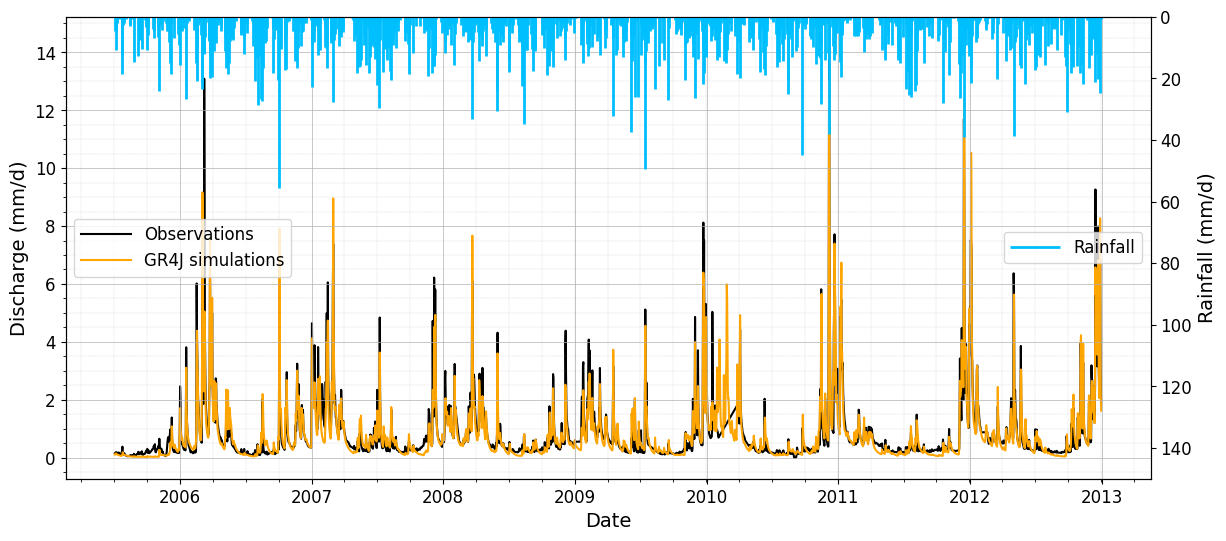

In [6]:
## init of figures
def inifig(xdim, ydim):
    fig = plt.figure(figsize = (xdim, ydim))
    ax = plt.subplot(1,1,1)
    ax.clear()
    ax.grid(which = 'minor', color = 'grey', linestyle = '-.', linewidth = 0.1)
    ax.grid(which = "major", linewidth = 0.5)
    ax.minorticks_on()
    ax.tick_params(axis = "y", labelsize = 12)
    ax.tick_params(axis = "x", labelsize = 12)
    return fig, ax

## plotting
figh, axh = inifig(14,6)
axh.plot(np.array(pd.to_datetime(data_cat.date[msk_test])), obs_t, color='black', linestyle='solid', 
         linewidth = 1.5, zorder = 0, label = "Observations")
axh.plot(np.array(pd.to_datetime(data_cat.date[msk_test])), preds_gr,color='orange', linestyle='solid',
         linewidth = 1.5, zorder = 1, label = "GR4J simulations")

axh.set_xlabel("Date", fontsize = 14)
axh.set_ylabel("Discharge (mm/d)", fontsize = 14)
ax_ = axh.twinx()
zero_precip_msk  = np.where(data_cat.precipitation > 0, True, False)
msk_test_precip  = (data_cat.index.values >= pd.to_datetime(beg_test))*(data_cat.index.values <= pd.to_datetime(end_test))*zero_precip_msk
ax_.vlines(data_cat.index.values[msk_test_precip], ymin = 0, ymax = data_cat.precipitation.values[msk_test_precip],
           color='deepskyblue', label = "Rainfall", linewidth = 2.)
ax_.set_ylim(0, 150)
ax_.invert_yaxis()
ax_.set_ylabel('Rainfall (mm/d)', fontsize = 14)
ax_.tick_params(axis = "y", labelsize = 12)
axh.legend(loc = "center left", handlelength = 3, fontsize = 12)
ax_.legend(loc = "center right", handlelength = 3, fontsize = 12)
plt.show()